In [171]:
# Import libraries
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

In [172]:
# Read in raw data files
df_train = pd.read_csv('credit_train.csv')
df_test = pd.read_csv('credit_test.csv')

In [173]:
# Concatenate raw data files into one dataframe
df = pd.concat([df_train, df_test])

/Users/cookiepoon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [174]:
print("There are", df.shape[0], "before NaN rows removal")

There are 110867 before NaN rows removal


In [175]:
df.isna().sum()/len(df)

Annual Income                   0.198454
Bankruptcies                    0.009859
Credit Score                    0.198454
Current Credit Balance          0.007820
Current Loan Amount             0.007820
Customer ID                     0.007820
Home Ownership                  0.007820
Loan ID                         0.007820
Loan Status                     0.098018
Maximum Open Credit             0.007838
Monthly Debt                    0.007820
Months since last delinquent    0.535001
Number of Credit Problems       0.007820
Number of Open Accounts         0.007820
Purpose                         0.007820
Tax Liens                       0.007919
Term                            0.007820
Years in current job            0.049753
Years of Credit History         0.007820
dtype: float64

In [176]:
# Remove rows which are completely null from dataframe
df = df[df.isnull().sum(axis=1) < df.shape[1]]

In [177]:
print( "There are", df.shape[0], "after NaN rows removed")

There are 110000 after NaN rows removed


 #### Deal with incorrect continuous values

In [178]:
df.describe()

,Annual Income,Bankruptcies,Credit Score,Current Credit Balance,Current Loan Amount,Maximum Open Credit,Monthly Debt,Months since last delinquent,Number of Credit Problems,Number of Open Accounts,Tax Liens,Years of Credit History
count,8.886500e+04,109774.000000,88865.000000,1.100000e+05,1.100000e+05,1.099980e+05,110000.000000,51553.000000,110000.000000,110000.000000,109989.000000,110000.000000
mean,1.377449e+06,0.117614,1076.594644,2.942822e+05,1.174621e+07,7.541012e+05,18468.526823,34.907086,0.168055,11.124491,0.029448,18.202485
std,1.063920e+06,0.351290,1475.581902,3.772773e+05,3.176716e+07,8.014002e+06,12195.564391,21.965315,0.484389,5.011093,0.261054,7.015575
min,7.662700e+04,0.000000,585.000000,0.000000e+00,1.080200e+04,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,3.600000
25%,8.488440e+05,0.000000,705.000000,1.121950e+05,1.795860e+05,2.731575e+05,10211.930000,16.000000,0.000000,8.000000,0.000000,13.500000
50%,1.173459e+06,0.000000,724.000000,2.096650e+05,3.120260e+05,4.673900e+05,16202.440000,32.000000,0.000000,10.000000,0.000000,16.900000
75%,1.651670e+06,0.000000,741.000000,3.674838e+05,5.239300e+05,7.831945e+05,23997.522500,51.000000,0.000000,14.000000,0.000000,21.700000
max,1.655574e+08,7.000000,7510.000000,3.287897e+07,1.000000e+08,1.539738e+09,435843.280000,176.000000,15.000000,76.000000,15.000000,70.500000


From the data distribution, maximum credit score is 7510 which is way more than minimum credit score 585，thus the credit score above 850 is requied to be reduced 10X smaller.

In [179]:
# Replace invalid credit scores (above 850 with an extra 0 entered) with credit score 10X smaller
df['Credit Score'] = np.where(df['Credit Score'] > 850, df['Credit Score']/10, df['Credit Score'])

In [180]:
# Drop rows with contaminated credit score (invalid credit score value)
df = df[df['Credit Score'] <= 850]
df = df.reset_index(drop=True)

#### Deal with Incorrect categorical values

In [181]:
df.select_dtypes('object').nunique()

Customer ID             72344
Home Ownership              4
Loan ID                 72344
Loan Status                 2
Purpose                    16
Term                        2
Years in current job       11
dtype: int64

In [182]:
#observe meaingful categorical variables values
df[["Home Ownership","Loan Status", "Purpose","Term"]].head(10)

,Home Ownership,Loan Status,Purpose,Term
0,Home Mortgage,Fully Paid,Home Improvements,Short Term
1,Own Home,Fully Paid,Debt Consolidation,Short Term
2,Own Home,Fully Paid,Debt Consolidation,Long Term
3,Home Mortgage,Charged Off,Debt Consolidation,Short Term
4,Home Mortgage,Fully Paid,Debt Consolidation,Short Term
5,Rent,Fully Paid,Debt Consolidation,Short Term
6,Rent,Fully Paid,Debt Consolidation,Short Term
7,Rent,Fully Paid,Debt Consolidation,Short Term
8,Own Home,Fully Paid,Debt Consolidation,Short Term
9,Rent,Fully Paid,Debt Consolidation,Short Term


From the unique values of all meaningful categorical columns, Home Ownership tends to have only 3 types of values as "Home Mortgage", "Own Home" and "Rent", the other one value might be an erroneous value.
There are 16 types of values for "Purpose". Some values within "Purpose" might be redundant can be replaced.

In [183]:
#check Home Ownership
print(df['Home Ownership'].unique())
#'Home Mortgage' and "HaveMortgage" are very similar, the value with fewer counts can be replaced with the value with more counts

['Home Mortgage' 'Own Home' 'Rent' 'HaveMortgage']


In [184]:
df['Home Ownership'].value_counts()

Home Mortgage    42954
Rent             37497
Own Home          8218
HaveMortgage       196
Name: Home Ownership, dtype: int64

The counts of "HaveMortgage" are less than "Homw Mortgage", "HaveMortgage" can be replaced with "Home Mortgage"


In [185]:
df['Home Ownership'] = df['Home Ownership'].replace('HaveMortgage', 'Home Mortgage')
df['Home Ownership'].value_counts()

Home Mortgage    43150
Rent             37497
Own Home          8218
Name: Home Ownership, dtype: int64

In [186]:
#check Purpose
df['Purpose'].value_counts()

Debt Consolidation      69611
other                    5478
Home Improvements        5190
Other                    2888
Business Loan            1412
Buy a Car                1137
Medical Bills            1023
Buy House                 621
Take a Trip               509
major_purchase            325
small_business            260
moving                    135
wedding                    96
Educational Expenses       94
vacation                   77
renewable_energy            9
Name: Purpose, dtype: int64

From the data value description from "Purpose" column, "other" and "Other" are the same, "small_business" will become"business loan" and "take a trip" can be replaced by "vacation". In this case, we can do some merging between values.

In [187]:
df['Purpose'] = df['Purpose'].replace({'small_business':'Business Loan','other':'Other','Take a Trip':'vacation'})
df['Purpose'].value_counts()

Debt Consolidation      69611
Other                    8366
Home Improvements        5190
Business Loan            1672
Buy a Car                1137
Medical Bills            1023
Buy House                 621
vacation                  586
major_purchase            325
moving                    135
wedding                    96
Educational Expenses       94
renewable_energy            9
Name: Purpose, dtype: int64

#### Deal with Redundant features

In [188]:
print('The dataset has ', df.shape[0], 'customers')

The dataset has  88865 customers


In [189]:
df.nunique()

Annual Income                   37853
Bankruptcies                        8
Credit Score                      167
Current Credit Balance          30994
Current Loan Amount             21046
Customer ID                     72344
Home Ownership                      3
Loan ID                         72344
Loan Status                         2
Maximum Open Credit             41584
Monthly Debt                    59476
Months since last delinquent      109
Number of Credit Problems          14
Number of Open Accounts            51
Purpose                            13
Tax Liens                          13
Term                                2
Years in current job               11
Years of Credit History           501
dtype: int64

Based on the unique counts for both Loan ID  and Customer ID as 72344, there are customer opens up more than 1 accounts because the total number of customers for the dataset is 88865, but there are only 72344 unique customers. Thus there are redundant records that we need to remove.

In [190]:
#check the duplicate rows
dup_id = df['Customer ID'].value_counts()[df['Customer ID'].value_counts()>1].index.values
dup_df = df.loc[df['Customer ID'].isin(dup_id)]
dup_df.head()

,Annual Income,Bankruptcies,Credit Score,Current Credit Balance,Current Loan Amount,Customer ID,Home Ownership,Loan ID,Loan Status,Maximum Open Credit,Monthly Debt,Months since last delinquent,Number of Credit Problems,Number of Open Accounts,Purpose,Tax Liens,Term,Years in current job,Years of Credit History
0,1167493.0,1.0,709.0,228190.0,445412.0,981165ec-3274-42f5-a3b4-d104041a9ca9,Home Mortgage,14dd8831-6af5-400b-83ec-68e61888a048,Fully Paid,416746.0,5214.74,NaN,1.0,6.0,Home Improvements,0.0,Short Term,8 years,17.2
2,806949.0,0.0,721.0,256329.0,347666.0,e777faab-98ae-45af-9a86-7ce5b33b1011,Own Home,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,Fully Paid,386958.0,8741.90,NaN,0.0,9.0,Debt Consolidation,0.0,Long Term,3 years,12.0
11,1821967.0,0.0,723.0,813694.0,666204.0,967e8733-7189-49b7-a3ab-6a1d0e1abdac,Home Mortgage,24e8c8bd-d10b-4dac-8b81-1da470ff5ecb,Fully Paid,2004618.0,17612.24,34.0,0.0,15.0,Debt Consolidation,0.0,Long Term,10+ years,22.0
18,1722654.0,0.0,688.0,107559.0,465410.0,cbe53e22-ba67-4eaf-a4fb-c5acdd12ec66,Rent,578c8e10-3214-4491-bdbc-b1695ef8ff87,Fully Paid,488356.0,15647.45,30.0,0.0,7.0,Buy House,0.0,Long Term,3 years,22.3
19,1029857.0,0.0,724.0,138339.0,99999999.0,9baf6d5d-f744-4332-abb0-e939b75cde40,Rent,0c14cb77-29a3-4964-9198-0c43f5f982b0,Fully Paid,221232.0,13817.18,NaN,0.0,6.0,Debt Consolidation,0.0,Short Term,1 year,12.0


In [191]:
#check number of duplicate values and drop duplicate values
print('There are', dup_df.shape[0], 'duplicate values.')
df = df.drop_duplicates()
print("There are", df.shape[0], "values remaining after dropping duplicates.")

There are 33042 duplicate values.
There are 78650 values remaining after dropping duplicates.


#### Deal with missing values

In [192]:
# See how many missing values per column
df.isna().sum()/len(df)

Annual Income                   0.000000
Bankruptcies                    0.002123
Credit Score                    0.000000
Current Credit Balance          0.000000
Current Loan Amount             0.000000
Customer ID                     0.000000
Home Ownership                  0.000000
Loan ID                         0.000000
Loan Status                     0.101958
Maximum Open Credit             0.000013
Monthly Debt                    0.000000
Months since last delinquent    0.535677
Number of Credit Problems       0.000000
Number of Open Accounts         0.000000
Purpose                         0.000000
Tax Liens                       0.000076
Term                            0.000000
Years in current job            0.042390
Years of Credit History         0.000000
dtype: float64

Missing values exist in "Bankruptcies", "Loan Status", "Months since last delinquent", "tax liens", and "years in current job" columns.

Missing values for "bankrupticies", "Months since last delinquent", 'tax liens" should be filled with 0 and missing values for other columns should be filled with mean values.

In [193]:
#fill in missing values with zero and observe distribution 
df['Months since last delinquent'] = df['Months since last delinquent'].fillna(0)
df['Bankruptcies'] = df['Bankruptcies'].fillna(0)
df['Tax Liens'] = df['Tax Liens'].fillna(0.0)

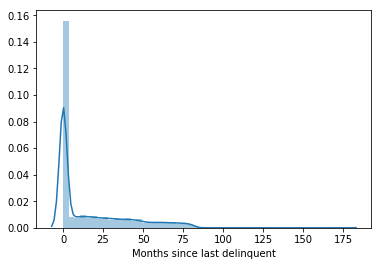

In [194]:
import seaborn as sns
sns.distplot(df['Months since last delinquent'])

In [195]:
#from the plot, we can divdie Months since last delinquent into following categories:
#0: no delinquent, 0~25: 2 years, 25~50: 4 years, 50 ~75: 6 years, >75: over 6 years
df['Delinquent Time'] = 0
df.loc[(df['Months since last delinquent'] == 0), 'Delinquent Time'] = 0
df.loc[(df['Months since last delinquent']>0)&(df['Months since last delinquent']<= 25),'Delinquent Time'] = 2
df.loc[(df['Months since last delinquent']>25)&(df['Months since last delinquent']<= 50),'Delinquent Time'] = 4
df.loc[(df['Months since last delinquent']>50)&(df['Months since last delinquent']<= 75),'Delinquent Time'] = 6
df.loc[(df['Months since last delinquent']>75),'Delinquent Time'] = 6

In [196]:
to_drop = 'Months since last delinquent'
df = df.drop(to_drop, axis = 1)

In [197]:
#exclude bankrupticies, tax linens, and number of credit problems from continuous columns
numeric = df.select_dtypes('number')
numeric_cols = numeric.columns
print(numeric_cols)

Index(['Annual Income', 'Bankruptcies', 'Credit Score',
       'Current Credit Balance', 'Current Loan Amount', 'Maximum Open Credit',
       'Monthly Debt', 'Number of Credit Problems', 'Number of Open Accounts',
       'Tax Liens', 'Years of Credit History', 'Delinquent Time'],
      dtype='object')


In [198]:
numeric.isna().sum()/len(df)

Annual Income                0.000000
Bankruptcies                 0.000000
Credit Score                 0.000000
Current Credit Balance       0.000000
Current Loan Amount          0.000000
Maximum Open Credit          0.000013
Monthly Debt                 0.000000
Number of Credit Problems    0.000000
Number of Open Accounts      0.000000
Tax Liens                    0.000000
Years of Credit History      0.000000
Delinquent Time              0.000000
dtype: float64

In [199]:
# Impute missing values for numerical data with the mean except bankruptcies and years in current job 
df[numeric.columns] = numeric.fillna(numeric.mean())

In [200]:
#check missing values in categorical columns
categoric = df.select_dtypes('object')
categoric = categoric.drop(columns = 'Years in current job')
print(categoric.columns)

Index(['Customer ID', 'Home Ownership', 'Loan ID', 'Loan Status', 'Purpose',
       'Term'],
      dtype='object')


In [201]:
# Impute missing values for categorical data with the mode
df[categoric.columns] = categoric.fillna(categoric.agg(lambda x: x.mode().values[0]))

In [202]:
#fill NaN for Years in current job with'< 1 year'
df['Years in current job'] = df['Years in current job'].fillna('< 1 year')

In [203]:
#confirm all columns missing values have been filled
df.isna().sum()

Annual Income                0
Bankruptcies                 0
Credit Score                 0
Current Credit Balance       0
Current Loan Amount          0
Customer ID                  0
Home Ownership               0
Loan ID                      0
Loan Status                  0
Maximum Open Credit          0
Monthly Debt                 0
Number of Credit Problems    0
Number of Open Accounts      0
Purpose                      0
Tax Liens                    0
Term                         0
Years in current job         0
Years of Credit History      0
Delinquent Time              0
dtype: int64

#### Feature Transformation

In [204]:
df[['Bankruptcies', 'Tax Liens', 'Number of Credit Problems']].nunique()

Bankruptcies                  8
Tax Liens                    13
Number of Credit Problems    14
dtype: int64

In [143]:
#explore Bankruptcies, Tax Liens and Number of Credit Problems values and transform each column into categorical columns






In [111]:
# Label encode categorical columns
le = LabelEncoder()
df[categoric.columns] = df[categoric.columns].apply(le.fit_transform)
df.head()

,Annual Income,Bankruptcies,Credit Score,Current Credit Balance,Current Loan Amount,Customer ID,Home Ownership,Loan ID,Loan Status,Maximum Open Credit,Monthly Debt,Number of Credit Problems,Number of Open Accounts,Purpose,Tax Liens,Term,Years in current job,Years of Credit History,Delinquent Time
0,1167493.0,1.0,709.0,228190.0,445412.0,43043,1,5898,1,416746.0,5214.74,1.0,6.0,5,0.0,1,8 years,17.2,0
1,2231892.0,0.0,741.0,297996.0,99999999.0,26873,2,22377,1,750090.0,29200.53,1.0,18.0,3,0.0,1,8 years,14.9,4
2,806949.0,0.0,721.0,256329.0,347666.0,65397,2,33793,1,386958.0,8741.90,0.0,9.0,3,0.0,0,3 years,12.0,0
3,896857.0,0.0,729.0,215308.0,206602.0,22612,1,39047,0,272448.0,16367.74,0.0,6.0,3,0.0,1,10+ years,17.3,0
4,1184194.0,1.0,730.0,122170.0,217646.0,40916,1,11116,1,272052.0,10855.08,1.0,13.0,3,0.0,1,< 1 year,19.6,2


In [112]:
# Convert 'Years in current job' to numerical column - 
# Note: Numerical tranformation converts '< 1 year' to 0 and '10+ years' to 10 for simplicity
df['Years in current job'] = df['Years in current job'].replace({'< 1 year':0, '1 year': 1, '2 years': 2,
                                                                 '3 years':3, '4 years':4, '5 years':5, 
                                                                 '6 years':6, '7 years':7, '8 years':8,
                                                                 '9 years': 9, '10+ years': 10})
df.head()

,Annual Income,Bankruptcies,Credit Score,Current Credit Balance,Current Loan Amount,Customer ID,Home Ownership,Loan ID,Loan Status,Maximum Open Credit,Monthly Debt,Number of Credit Problems,Number of Open Accounts,Purpose,Tax Liens,Term,Years in current job,Years of Credit History,Delinquent Time
0,1167493.0,1.0,709.0,228190.0,445412.0,43043,1,5898,1,416746.0,5214.74,1.0,6.0,5,0.0,1,8,17.2,0
1,2231892.0,0.0,741.0,297996.0,99999999.0,26873,2,22377,1,750090.0,29200.53,1.0,18.0,3,0.0,1,8,14.9,4
2,806949.0,0.0,721.0,256329.0,347666.0,65397,2,33793,1,386958.0,8741.90,0.0,9.0,3,0.0,0,3,12.0,0
3,896857.0,0.0,729.0,215308.0,206602.0,22612,1,39047,0,272448.0,16367.74,0.0,6.0,3,0.0,1,10,17.3,0
4,1184194.0,1.0,730.0,122170.0,217646.0,40916,1,11116,1,272052.0,10855.08,1.0,13.0,3,0.0,1,0,19.6,2


#### Feature Normalization 

In [112]:
# Get more insight into 'Credit Score' column
df['Credit Score'].describe()

count    88865.000000
mean       716.323930
std         28.291419
min        585.000000
25%        703.000000
50%        722.000000
75%        739.000000
max        751.000000
Name: Credit Score, dtype: float64

In [113]:
# Add 'Credit Score Range' column
df['Credit Score Range'] = pd.cut(df['Credit Score'], 10)
df.head()

,Annual Income,Bankruptcies,Credit Score,Current Credit Balance,Current Loan Amount,Customer ID,Home Ownership,Loan ID,Loan Status,Maximum Open Credit,Monthly Debt,Number of Credit Problems,Number of Open Accounts,Purpose,Tax Liens,Term,Years in current job,Years of Credit History,Delinquent Time,Credit Score Range
0,1167493.0,1.0,709.0,228190.0,445412.0,43043,1,5898,1,416746.0,5214.74,1.0,6.0,5,0.0,1,8,17.2,0,"(701.2, 717.8]"
1,2231892.0,0.0,741.0,297996.0,99999999.0,26873,2,22377,1,750090.0,29200.53,1.0,18.0,3,0.0,1,8,14.9,4,"(734.4, 751.0]"
2,806949.0,0.0,721.0,256329.0,347666.0,65397,2,33793,1,386958.0,8741.90,0.0,9.0,3,0.0,0,3,12.0,0,"(717.8, 734.4]"
3,896857.0,0.0,729.0,215308.0,206602.0,22612,1,39047,0,272448.0,16367.74,0.0,6.0,3,0.0,1,10,17.3,0,"(717.8, 734.4]"
4,1184194.0,1.0,730.0,122170.0,217646.0,40916,1,11116,1,272052.0,10855.08,1.0,13.0,3,0.0,1,0,19.6,2,"(717.8, 734.4]"


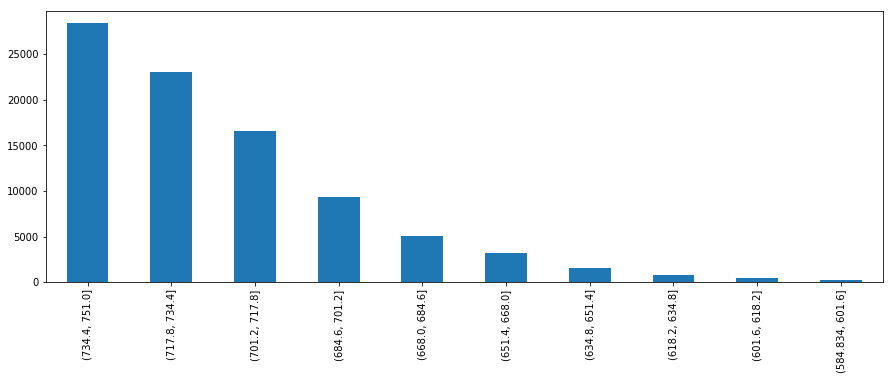

In [114]:
df['Credit Score Range'].value_counts().plot(kind='bar',figsize=(15,5))

In [116]:
# Normalize continuous columns
numeric = df.select_dtypes('number')
transformer = preprocessing.MinMaxScaler()
numeric_normalized = transformer.fit_transform(numeric.values)
df[numeric.columns] = numeric_normalized

In [117]:
# View final dataframe after processing
df

,Annual Income,Bankruptcies,Credit Score,Current Credit Balance,Current Loan Amount,Customer ID,Home Ownership,Loan ID,Loan Status,Maximum Open Credit,Monthly Debt,Number of Credit Problems,Number of Open Accounts,Purpose,Tax Liens,Term,Years in current job,Years of Credit History,Delinquent Time,Credit Score Range
0,0.006592,0.142857,0.746988,0.006940,0.004342,0.594985,0.333333,0.081528,1.0,0.000271,0.011965,0.066667,0.066667,0.333333,0.000000,1.0,0.8,0.202096,0.000000,"(701.2, 717.8]"
1,0.013024,0.000000,0.939759,0.009063,1.000000,0.371466,0.666667,0.309318,1.0,0.000487,0.066998,0.066667,0.226667,0.200000,0.000000,1.0,0.8,0.167665,0.666667,"(734.4, 751.0]"
2,0.004413,0.000000,0.819277,0.007796,0.003365,0.903985,0.666667,0.467122,1.0,0.000251,0.020057,0.000000,0.106667,0.200000,0.000000,0.0,0.3,0.124251,0.000000,"(717.8, 734.4]"
3,0.004957,0.000000,0.867470,0.006549,0.001954,0.312567,0.333333,0.539748,0.0,0.000177,0.037554,0.000000,0.066667,0.200000,0.000000,1.0,1.0,0.203593,0.000000,"(717.8, 734.4]"
4,0.006693,0.142857,0.873494,0.003716,0.002064,0.565583,0.333333,0.153657,1.0,0.000177,0.024906,0.066667,0.160000,0.200000,0.000000,1.0,0.0,0.238024,0.333333,"(717.8, 734.4]"
5,0.015002,0.000000,0.560241,0.013296,0.005376,0.686563,1.000000,0.544144,1.0,0.000360,0.042814,0.000000,0.040000,0.200000,0.000000,1.0,0.2,0.282934,0.666667,"(668.0, 684.6]"
6,0.008328,0.000000,0.927711,0.020364,0.002047,0.138742,1.000000,0.042962,1.0,0.000663,0.090119,0.000000,0.253333,0.200000,0.000000,1.0,0.0,0.152695,0.000000,"(734.4, 751.0]"
7,0.003855,0.000000,0.861446,0.006204,1.000000,0.053855,1.000000,0.198139,1.0,0.000188,0.027191,0.000000,0.200000,0.200000,0.000000,1.0,0.3,0.184132,1.000000,"(717.8, 734.4]"
8,0.004227,0.000000,0.933735,0.004078,1.000000,0.067429,0.666667,0.251344,1.0,0.000143,0.026565,0.000000,0.066667,0.200000,0.000000,1.0,0.0,0.071856,0.333333,"(734.4, 751.0]"
9,0.008970,0.142857,0.951807,0.006860,1.000000,0.562819,1.000000,0.006981,1.0,0.000322,0.040291,0.066667,0.120000,0.200000,0.000000,1.0,0.4,0.143713,0.000000,"(734.4, 751.0]"


In [118]:
# Write processed dataframe to csv file called 'credit.csv'
df.to_csv('/Users/cookiepoon/Desktop/ECS171G12Proj-main/datasets/credit2.csv', index=False)